In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

random_state = np.random.get_state()

In [2]:
class Bandit(object):
    def __init__(self, k_arm=10, epsilon=0.0, nonstationary=False, time_step=None, initial=0.0, upper_confidence_bound=None,
                 stochastic_gradient_ascent=None, stochastic_gradient_ascent_baseline=False, true_reward=0):
        self.k_arm = k_arm
        self.epsilon = epsilon
        self.nonstationary = nonstationary
        self.time_step = time_step
        self.action_indices = np.arange(self.k_arm, dtype=np.int)
        self.initial = initial
        self.UCB = upper_confidence_bound
        self.gradient = stochastic_gradient_ascent
        self.gradient_baseline = stochastic_gradient_ascent_baseline
        self.true_reward = true_reward
        self.average_reward = 0

    def reset(self):
        self.q_true = np.random.normal(loc=0, scale=1, size=self.k_arm) + self.true_reward
        self.q_estimation = np.zeros(self.k_arm) + self.initial
        self.time = 0
        self.action_count = np.zeros(self.k_arm)
        self.best_action = np.argmax(self.q_true)
        self.average_reward = 0
    
    def act(self):
        if self.UCB is not None:
            UCB_estimation = self.q_estimation + self.UCB * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        elif self.gradient is not None:
            exp_est = np.exp(self.q_estimation)
            self.actoin_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.action_indices, p=self.actoin_prob)

        if np.random.random_sample() < self.epsilon:
            return np.random.choice(self.action_indices)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    
    def step(self, action):
        if self.nonstationary:  # 비정상적 문제 적용
            self.q_true += np.random.normal(loc=0, scale=0.01, size=self.q_true.shape)
            self.best_action = np.argmax(self.q_true)

        reward = np.random.normal(loc=self.q_true, scale=1)[action]

        self.time += 1
        self.action_count[action] += 1
        self.average_reward = self.average_reward + (reward - self.average_reward) / self.time

        if self.gradient is not None:
            one_hot = np.eye(self.k_arm)[action]
            if self.gradient_baseline:
                average_reward_baseline = self.average_reward
            else:
                average_reward_baseline = 0
            self.q_estimation = self.q_estimation + self.time_step * (reward - average_reward_baseline) * (one_hot - self.actoin_prob) 
        elif self.time_step is not None:
            self.q_estimation[action] = self.q_estimation[action] + (reward - self.q_estimation[action]) * self.time_step
        else:
            self.q_estimation[action] = self.q_estimation[action] + (reward - self.q_estimation[action]) / self.action_count[action]
        return reward

In [3]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_count = np.zeros(rewards.shape)

    for i, bandit in enumerate(bandits):
        np.random.set_state(random_state)
        for r in trange(runs, desc="{}/{} : eps = {}, grad = {}, step = {} UCB = {}, init = {} ".format(
                                    i+1, len(bandits), bandit.epsilon, bandit.gradient,
                                    bandit.time_step, bandit.UCB, bandit.initial)):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward

                if action == bandit.best_action:
                    best_action_count[i, r, t] = 1

    mean_rewards = rewards.mean(axis=1)
    mean_best_action_count = best_action_count.mean(axis=1)
    return mean_rewards, mean_best_action_count

In [4]:
def figure_2_6(runs=2000, time=1000):
    labels = [
        "epsilon-greedy",
        "gradient bandit",
        "UCB",
        "optimistic initialization"]
    generators = [
        lambda epsilon: Bandit(epsilon=epsilon),
        lambda time_step: Bandit(stochastic_gradient_ascent=True, time_step=time_step, stochastic_gradient_ascent_baseline=True),
        lambda UCB: Bandit(upper_confidence_bound=UCB),
        lambda initial: Bandit(initial=initial, time_step=0.1)]
    parameters = [
        np.arange(-7, -1, dtype=np.float),
        np.arange(-5, 2, dtype=np.float),
        np.arange(-4, 3, dtype=np.float),
        np.arange(-2, 5, dtype=np.float)]

    bandits = []
    for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits.append(generator(pow(2, param)))
    
    mean_rewards, mean_best_action_count = simulate(runs, time, bandits)
    mean_rewards = np.mean(mean_rewards, axis=1)
    mean_best_action_count = np.mean(mean_best_action_count, axis=1)

    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, mean_rewards[i:i+l], label=label)
        i += l
    plt.xlabel("{}\n{}".format(r"parameter($2^x$)", r"$\epsilon,\ \alpha,\ c,\ Q_0$"))
    plt.ylabel("aerage reward")
    plt.legend()

    plt.subplot(2, 1, 2)
    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, mean_best_action_count[i:i+l], label=label)
        i += l
    plt.xlabel("{}\n{}".format(r"parameter($2^x$)", r"$\epsilon,\ \alpha,\ c,\ Q_0$"))
    plt.ylabel("% optimal action")
    plt.legend()

    plt.show()

1/27 : eps = 0.0078125, grad = None, step = None UCB = None, init = 0.0 : 100%|██████████| 2000/2000 [03:35<00:00,  9.30it/s]
2/27 : eps = 0.015625, grad = None, step = None UCB = None, init = 0.0 : 100%|██████████| 2000/2000 [02:39<00:00, 12.55it/s]
3/27 : eps = 0.03125, grad = None, step = None UCB = None, init = 0.0 : 100%|██████████| 2000/2000 [02:51<00:00, 11.68it/s]
4/27 : eps = 0.0625, grad = None, step = None UCB = None, init = 0.0 : 100%|██████████| 2000/2000 [02:34<00:00, 12.93it/s]
5/27 : eps = 0.125, grad = None, step = None UCB = None, init = 0.0 : 100%|██████████| 2000/2000 [02:24<00:00, 13.83it/s]
6/27 : eps = 0.25, grad = None, step = None UCB = None, init = 0.0 : 100%|██████████| 2000/2000 [02:17<00:00, 14.57it/s]
7/27 : eps = 0.0, grad = True, step = 0.03125 UCB = None, init = 0.0 : 100%|██████████| 2000/2000 [04:38<00:00,  7.19it/s]
8/27 : eps = 0.0, grad = True, step = 0.0625 UCB = None, init = 0.0 : 100%|██████████| 2000/2000 [04:32<00:00,  7.33it/s]
9/27 : eps = 0

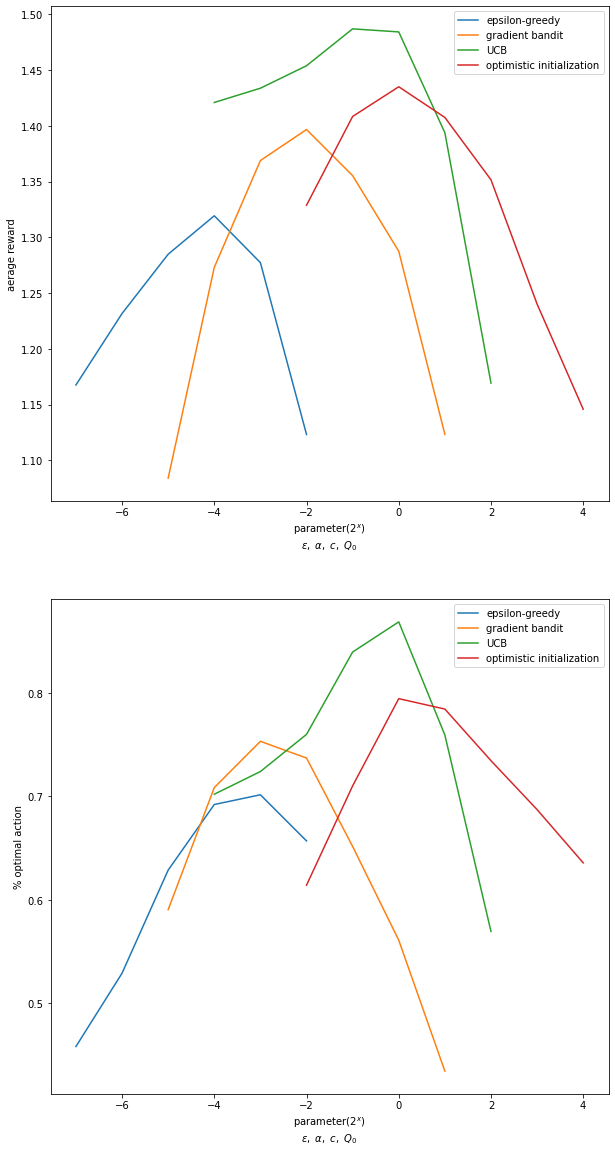

In [5]:
figure_2_6()

## Exercise 2.11

In [8]:
def simulate2(runs, time, bandits):
    rewards = np.zeros((len(bandits), time))
    best_action_count = np.zeros(rewards.shape)

    for i, bandit in enumerate(bandits):
        np.random.set_state(random_state)
        for r in trange(runs, desc="{}/{} : eps = {}, grad = {}, step = {} UCB = {}, init = {} ".format(
                                    i+1, len(bandits), bandit.epsilon, bandit.gradient,
                                    bandit.time_step, bandit.UCB, bandit.initial)):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)

                if t >= time // 2:
                    rewards[i, t] += reward

                    if action == bandit.best_action:
                        best_action_count[i, t] += 1

    print(rewards.shape)
    mean_rewards = rewards / runs
    mean_best_action_count = best_action_count / runs
    return mean_rewards, mean_best_action_count

In [9]:
def exercise_2_11(runs=2000, time=1000):
    labels = [
        "epsilon-greedy",
        "epsilon-greedy (time step = 0.1)",
        "gradient bandit",
        "UCB",
        "optimistic initialization"]
    generators = [
        lambda epsilon: Bandit(epsilon=epsilon, nonstationary=True),
        lambda epsilon: Bandit(epsilon=epsilon, time_step=0.1, nonstationary=True),
        lambda time_step: Bandit(stochastic_gradient_ascent=True, time_step=time_step, stochastic_gradient_ascent_baseline=True,
                                 nonstationary=True),
        lambda UCB: Bandit(upper_confidence_bound=UCB, nonstationary=True),
        lambda initial: Bandit(initial=initial, time_step=0.1, nonstationary=True)]
    parameters = [
        np.arange(-7, -1, dtype=np.float),
        np.arange(-7, -1, dtype=np.float),
        np.arange(-5, 2, dtype=np.float),
        np.arange(-4, 3, dtype=np.float),
        np.arange(-2, 5, dtype=np.float)]

    bandits = []
    for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits.append(generator(pow(2, param)))
    
    mean_rewards, mean_best_action_count = simulate2(runs, time, bandits)
    mean_rewards = np.mean(mean_rewards[:, -time//2:], axis=1)
    mean_best_action_count = np.mean(mean_best_action_count[:, -time//2:], axis=1)

    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, mean_rewards[i:i+l], label=label)
        i += l
    plt.xlabel("{}\n{}".format(r"parameter($2^x$)", r"$\epsilon,\ \alpha,\ c,\ Q_0$"))
    plt.ylabel("aerage reward")
    plt.legend()

    plt.subplot(2, 1, 2)
    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, mean_best_action_count[i:i+l], label=label)
        i += l
    plt.xlabel("{}\n{}".format(r"parameter($2^x$)", r"$\epsilon,\ \alpha,\ c,\ Q_0$"))
    plt.ylabel("% optimal action")
    plt.legend()

    plt.show()

In [10]:
exercise_2_11(time=200000)

1/33 : eps = 0.0078125, grad = None, step = None UCB = None, init = 0.0 :   0%|          | 2/2000 [00:41<11:35:05, 20.87s/it]


KeyboardInterrupt: 